In [49]:
import pandas as pd
import numpy as np

# 1) Read the Excel file
df = pd.read_excel("e_redes_perfil_consumo.xlsx")

# 2) Set header from 3rd row and clean
df.columns = df.iloc[2]
df = df.drop([0, 1, 2]).reset_index(drop=True)

# 3) Choose columns: 1st NaN (date), 2nd NaN (hour) + valid ones
is_nan = pd.isna(df.columns)
first_nan_idx  = np.flatnonzero(is_nan)[0]
second_nan_idx = np.flatnonzero(is_nan)[1]
non_nan_idx = list(np.flatnonzero(~is_nan))
df = df.iloc[:, [first_nan_idx, second_nan_idx] + non_nan_idx]

# 4) Rename columns
df.columns = ["date", "hour"] + df.columns.tolist()[2:]

# 5) Create proper datetime with 15-minute intervals
# Get the date part
df["date_only"] = pd.to_datetime(df["date"]).dt.date

# Create 15-minute intervals: 00:15, 00:30, 00:45, 01:00, 01:15, etc.
# Each day has 96 intervals (24 hours * 4 intervals per hour)
intervals_per_day = 96
df["interval_in_day"] = df.index % intervals_per_day

# Convert interval number to time
# interval 0 = 00:15, interval 1 = 00:30, interval 2 = 00:45, interval 3 = 01:00, etc.
df["minutes_from_midnight"] = (df["interval_in_day"] + 1) * 15

# Create proper datetime
df["time"] = pd.to_datetime(df["date_only"].astype(str)) + pd.to_timedelta(df["minutes_from_midnight"], unit='minutes')

# 6) Remove temporary and old columns, put 'time' first
df = df.drop(columns=["date", "hour", "date_only", "interval_in_day", "minutes_from_midnight"])
df = df[["time"] + [c for c in df.columns if c != "time"]]

In [62]:
def un_normal(total_year,permil):
    return permil / 1000 * total_year


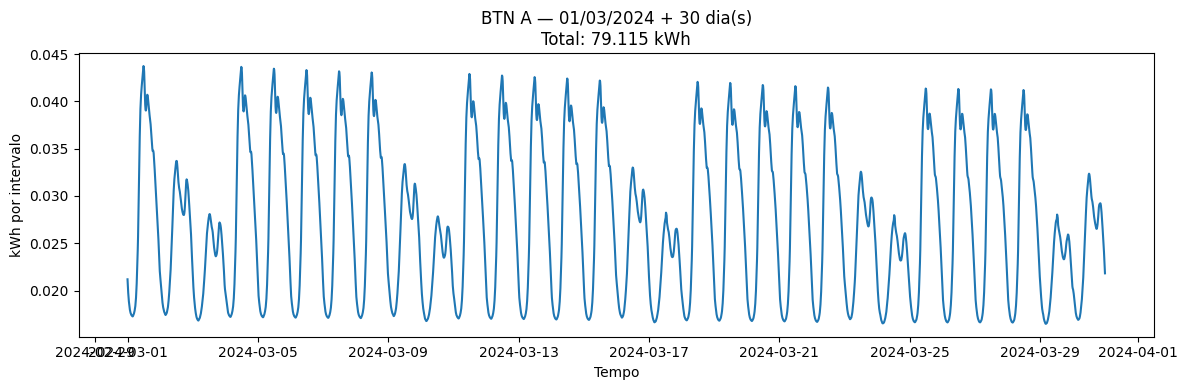

Período: [2024-03-01 00:00:00 → 2024-03-31 00:00:00)
Consumo TOTAL no período: 79.115 kWh

Consumo diário (kWh):
time
2024-03-01    2.893
2024-03-02    2.490
2024-03-03    2.183
2024-03-04    2.883
2024-03-05    2.874
2024-03-06    2.866
2024-03-07    2.858
2024-03-08    2.851
2024-03-09    2.462
2024-03-10    2.163
2024-03-11    2.840
2024-03-12    2.831
2024-03-13    2.822
2024-03-14    2.813
2024-03-15    2.800
2024-03-16    2.434
2024-03-17    2.158
2024-03-18    2.789
2024-03-19    2.783
2024-03-20    2.772
2024-03-21    2.765
2024-03-22    2.756
2024-03-23    2.400
2024-03-24    2.134
2024-03-25    2.748
2024-03-26    2.746
2024-03-27    2.744
2024-03-28    2.740
2024-03-29    2.139
2024-03-30    2.379
Freq: D, dtype: float64


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

def analyze_window(df,
                   col='BTN A',
                   start='10/01/2023',  # formato dd/mm/aaaa
                   days=5,
                   is_power_kw=False):
    """
    Filtra df pelo período [start, start+days), desenha gráfico e imprime consumo total.
    - df: DataFrame com colunas 'time' e a coluna de consumo/potência (ex: 'BTN A')
    - col: nome da coluna de interesse
    - start: string com data de início (dd/mm/aaaa)
    - days: número de dias a partir de start (inteiro)
    - is_power_kw: se True, interpreta a coluna como kW médios por 15 min e converte para kWh
    """

    # 1) Garantir datetime correto na coluna 'time' (formato do teu exemplo: "YYYY-MM-DD HH:MM:SS")
    ts = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    # 2) Interpretar a data de início no formato PT (dd/mm/aaaa)
    start_dt = pd.to_datetime(start, dayfirst=True)
    end_dt = start_dt + timedelta(days=days)

    # 3) Filtrar janela [start, end)
    mask = (ts >= start_dt) & (ts < end_dt)
    if not mask.any():
        raise ValueError("Não há dados no intervalo pedido — confirma as datas.")

    # 4) Extrair série e garantir float
    s = pd.to_numeric(df.loc[mask, col], errors='coerce').astype(float)
    t = ts.loc[mask]

    # 5) Se a coluna estiver em kW médio por 15 min, converter para kWh do intervalo
    #    (energia = potência * 0,25 h)
    if is_power_kw:
        s_interval_kwh = s * 0.25
        y_label = 'kWh por intervalo (convertido de kW)'
    else:
        s_interval_kwh = s
        y_label = 'kWh por intervalo'

    # 6) Consumo total no período
    total_kwh = s_interval_kwh.sum()

    # 7) (Opcional) Consumo diário (útil para validação)
    serie = pd.Series(s_interval_kwh.values, index=t)
    consumo_diario = serie.resample('D').sum()

    # 8) Gráfico (15 min)
    plt.figure(figsize=(12, 4))
    plt.plot(t, s_interval_kwh.values)
    plt.title(f"{col} — {start_dt.strftime('%d/%m/%Y')} + {days} dia(s)\nTotal: {total_kwh:.3f} kWh")
    plt.xlabel('Tempo')
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()

    # 9) Mostrar totais
    print(f"Período: [{start_dt} → {end_dt})")
    print(f"Consumo TOTAL no período: {total_kwh:.3f} kWh\n")
    print("Consumo diário (kWh):")
    print(consumo_diario.round(3))



analyze_window(df, col='BTN A', start='1/03/2024', days=30, is_power_kw=False)



In [51]:
BTN_A = df['BTN A'].values
time = df['time']

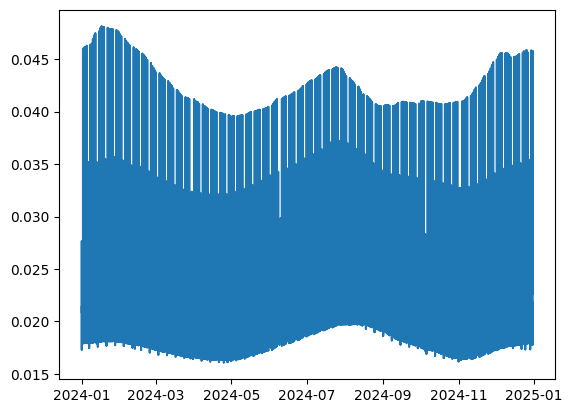

1000.0000000000011
